In [266]:
from Nim.agents import *
import random # random module for generating random games
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams # you need to alter rcParams after magic command "%matplotlib inline"
rcParams['figure.figsize'] = (6, 3) # set default figure size
rcParams['figure.facecolor'] = 'w'
from typing import List, Tuple
import pandas as pd
from math import log10

In [267]:
already_trained = True  # if True, uses training data from file instead of training

In [268]:
heaps = 1 # 5 max elements per heap
trials = 1000

save_dir = f"Modeling Misinformation Plots and Data/{heaps} Heap"
raw_data_path = save_dir + '/' + f'Median Articles Until Convergence Raw Data ({heaps} Heaps, {trials} Trials).csv'

if already_trained:
    raw_data = pd.read_csv(raw_data_path, index_col='Percent of Optimal')
else:
    raw_data = pd.DataFrame(index=list(range(101)))
    raw_data.index.rename('Percent of Optimal', inplace=True)

In [269]:
def train_in_varied_environment(alt_train_opponent: str, start_percent: int = 0, trials: int = trials) -> Tuple[List]:
    percent_optimal_agents = list(range(start_percent, 101))
    games_until_convergence = [] # each entry is an y axis

    for trial in range(trials):
        games_until_convergence.append([])

        for percent_optimal in range(start_percent, 101):
            Qagent = QLearningAgent("Q Learning Agents/Varied Education Level", 'OptimalAgent', heaps, 5, 0.4, 1, 0.1, True)

            # make new entry
            games_until_convergence[-1].append(0)
            while Qagent.test_accuracy() != 1:
                if random.randint(1, 1000) == 1:
                    print(trial, percent_optimal, games_until_convergence[-1][-1], Qagent.test_accuracy()) # if Qagent does not converge we see where it fails

                # instead of checking every x (x is constant) games, we optimize this:
                # we check all values below 100 and then after 1% of total games->
                # we will be within 1% of true convergence amount
                # For the range 1-100 games we check 100 times, for range 10**x - 10**(x+2), we check ~ 460 times for x >=2 ->
                # super efficient: # of checks double if total games are squared!
                for game in range(max(1, games_until_convergence[-1][-1]//100)):
                    # find random opponent to train with
                    if random.randint(1, 100) <= percent_optimal:
                        Qagent.set_train_opponent("OptimalAgent")
                    else:
                        Qagent.set_train_opponent(alt_train_opponent)

                    # train
                    Qagent.train(1, 10) # saving is slow, so we don't save (make parameters: game > train_games)
                    games_until_convergence[-1][-1] += 1

    med_games_until_convergence = [sorted([games_until_convergence[j][i] for j in range(trials)])[trials//2] for i in range(len(percent_optimal_agents))]

    return percent_optimal_agents, med_games_until_convergence

In [270]:
def save_games_til_cnvg(percent_op: List[int], games: List[float],
                        title: str) -> None:
    for i in range(len(percent_op)):
        raw_data.loc[percent_op[i], title] = games[i]

    raw_data.to_csv(raw_data_path)

In [271]:
def plot_games_til_cnvg(percent_op: List[int], games: List[float],
                        hypothesis: str, title: str, trials: int, save_dir: str) -> None:
    """Initial data visualization"""

    # axis labels and title
    plt.xlabel("Percent of Optimal Sources", color='purple')
    plt.ylabel("Interactions Until Convergence", color='purple')
    plt.title(title, color='purple')

    # plot hypothesis
    f = lambda x: eval(hypothesis)
    hypothesis_y = [f(x) for x in percent_op]
    plt.plot(percent_op, hypothesis_y, label = f'Hypothesis: {hypothesis}')

    # actual trial data
    plt.plot(percent_op, games, label = f"Median ({trials} trials)")

    # legend
    plt.legend(loc="upper right")

    plt.savefig(save_dir + '/' + title + '.png')

In [272]:
def plot_games_til_cnvg_ratio(percent_op: List[int], games: List[float],
                        hypothesis: str, title: str, trials: int, save_dir: str) -> List[float]:
    """Further comparison of hypothesis games and actual games until convergence (ratio) with visualization"""

    f = lambda x: eval(hypothesis)

    fraction_actual_games = []
    for i in range(len(games)):
        fraction_actual_games.append(games[i]/f(percent_op[i]))

    # axis labels and title
    plt.xlabel("Percent of Optimal Sources", color='purple')
    plt.ylabel("Actual Interactions/Hypothesis Interactions", color='purple')
    plt.title(title, color='purple')

    # ratios
    plt.plot(percent_op, [1]*len(percent_op), label="y = 1")
    plt.plot(percent_op, fraction_actual_games, label=f"Ratio ({trials} trials)")
    plt.legend()

    plt.savefig(save_dir + '/' + title + '.png')

    return fraction_actual_games

In [273]:
# vary percentage of optimal agents in environment from 0, 1, 2 ... 100 (all others are random agents). the q-learning agent trains by picking a random agent in the environment as its opponent for each game. See when QLearningAgent converges (99.5% accuracy).
# run 3 times due to variability

if already_trained:
    med_games_until_convergence_random = list(raw_data['Random'].dropna())[1:]
    percent_optimal_agents_random = list(range(101-len(med_games_until_convergence_random), 101))
else:
    percent_optimal_agents_random,\
    med_games_until_convergence_random = \
        train_in_varied_environment("RandomAgent")

In [274]:
save_games_til_cnvg(percent_optimal_agents_random, med_games_until_convergence_random, "Random")

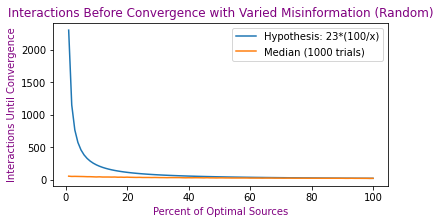

In [275]:
# Hypothesis:
# When 0% are optimal, converges at 89500 (median of 100 runs). When 100% are optimal, converges at 550 games (median of 5000 runs).
# Thus, we can assume a game with the random agent gets us 1/89500 of the way to convergence.
# Similarly, a game with the optimal agent gets us 1/550 of the way to convergence.
# Then, if x is the probability of facing an optimal agent, the expected value of amount to convergence per game is (x/550 + (1-x)/89500)
# Therefore, we expect to take 1/(x/550 + (1-x)/89500) games to converge

hypothesis_random = '1/((x/100)/23 + (1-(x/100))/59)'
hypothesis_random = '23*(100/x)'
plot_games_til_cnvg(percent_optimal_agents_random,
                    med_games_until_convergence_random,
                    hypothesis_random,
                    'Interactions Before Convergence with Varied Misinformation (Random)',
                    trials,
                    save_dir)

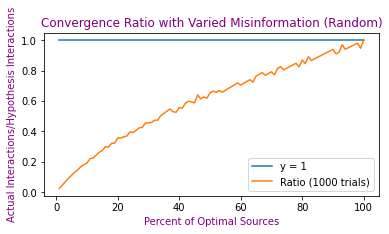

In [276]:
fraction_actual_games_random = plot_games_til_cnvg_ratio(percent_optimal_agents_random,
                                                         med_games_until_convergence_random,
                                                         hypothesis_random,
                                                         'Convergence Ratio with Varied Misinformation (Random)',
                                                         trials,
                                                         save_dir)

In [277]:
# Same training as above but now instead of RandomAgent, we use the ReverseOptimalAgent
# Note that the 0 data point is not used because the Q-learning agent fails to converge!
# The Q table converges on the wrong values! -> 0.27 accuracy after 1e6 games
# (4,) -> (0, 1) Q table believes that removing 1 element from the heap is always optimal
# (3) -> (2) -> 2 -> 0

if already_trained:
    med_games_until_convergence_revop = list(raw_data['Reverse Optimal'].dropna())[1:]
    percent_optimal_agents_revop = list(range(101-len(med_games_until_convergence_revop), 101))
else:
    percent_optimal_agents_revop,\
    med_games_until_convergence_revop = \
        train_in_varied_environment("ReverseOptimalAgent")

In [278]:
save_games_til_cnvg(percent_optimal_agents_revop, med_games_until_convergence_revop, "Reverse Optimal")

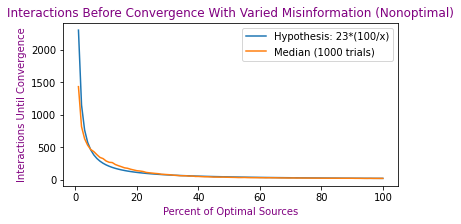

In [279]:
# Hypothesis
# In denominator of hypothesized games: the contribution from playing with ReverseOptimal Agent is
# (1-x)/infinity = 0 since it does not converge

hypothesis_revop = '1/((x/100)/23 + (1-(x/100))/17711)'
hypothesis_revop = '23*(100/x)'
plot_games_til_cnvg(percent_optimal_agents_revop,
                    med_games_until_convergence_revop,
                    hypothesis_revop,
                    'Interactions Before Convergence With Varied Misinformation (Nonoptimal)',
                    trials,
                    save_dir)

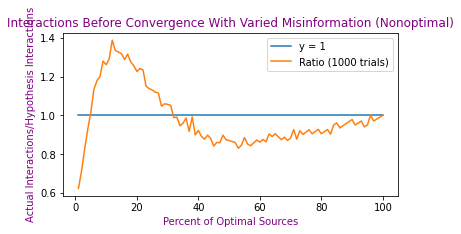

In [280]:
fraction_actual_games_revop = plot_games_til_cnvg_ratio(percent_optimal_agents_revop,
                                                        med_games_until_convergence_revop,
                                                        hypothesis_revop,
                                                        'Interactions Before Convergence With Varied Misinformation (Nonoptimal)',
                                                        trials,
                                                        save_dir)

In [281]:
# same training as above but now instead of reverseoptimalagent, we use randomreverseoptimalagent

if already_trained:
    med_games_until_convergence_ranrevop = list(raw_data['Random Reverse Optimal'].dropna())[1:]
    percent_optimal_agents_ranrevop = list(range(101-len(med_games_until_convergence_ranrevop), 101))
else:
    percent_optimal_agents_ranrevop,\
    med_games_until_convergence_ranrevop = \
        train_in_varied_environment("RandomReverseOptimalAgent")

In [282]:
save_games_til_cnvg(percent_optimal_agents_ranrevop, med_games_until_convergence_ranrevop, "Random Reverse Optimal")

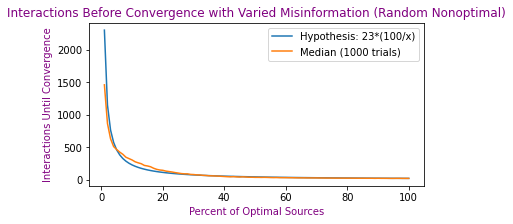

In [283]:
# Hypothesis
# In denominator of hypothesized games: the contribution from playing with ReverseOptimal Agent is
# (1-x)/infinity = 0 since it does not converge

hypothesis_ranrevop = '1/((x/100)/23 + (1-(x/100))/17536)'
hypothesis_ranrevop = '23*(100/x)'
# 23
# 1/23 + 1/23
# 0.9 + 0.09 + 0.09 ... + 0.00001
# 23/(x/100)
# x = 10
# 1/10
# 23/(10/100) = 23/(1/10) = 23*10 = 230 -> 230* 1/10 = 23
# x = percent of optimal agents
# '1/((x/100)/23)' = the number of games you need to play such that ~ played 23 games with the optimal agent
plot_games_til_cnvg(percent_optimal_agents_ranrevop,
                    med_games_until_convergence_ranrevop,
                    hypothesis_ranrevop,
                    'Interactions Before Convergence with Varied Misinformation (Random Nonoptimal)',
                    trials,
                    save_dir)

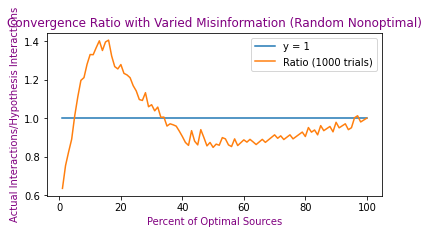

In [284]:
fraction_actual_games_ranrevop = plot_games_til_cnvg_ratio(percent_optimal_agents_ranrevop,
                                                           med_games_until_convergence_ranrevop,
                                                           hypothesis_ranrevop,
                                                           'Convergence Ratio with Varied Misinformation (Random Nonoptimal)',
                                                           trials,
                                                           save_dir)

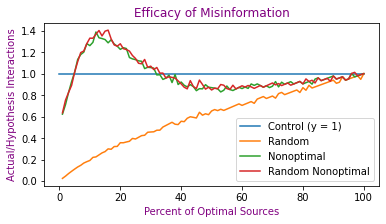

In [285]:
# Further comparison of hypothesis games and actual games until convergence (ratio) with visualization
# Plotting all comparisons now

# axis labels and title
plt.xlabel("Percent of Optimal Sources", color='purple')
plt.ylabel("Actual/Hypothesis Interactions", color='purple')
title = 'Efficacy of Misinformation'
plt.title(title, color='purple')

# ratios
plt.plot(list(range(101)), [1]*101, label="Control (y = 1)")
plt.plot(percent_optimal_agents_random, fraction_actual_games_random, label="Random")
plt.plot(percent_optimal_agents_revop, fraction_actual_games_revop, label="Nonoptimal")
plt.plot(percent_optimal_agents_ranrevop, fraction_actual_games_ranrevop, label="Random Nonoptimal")
plt.legend();
plt.savefig(save_dir + '/' + title + '.png', bbox_inches='tight')

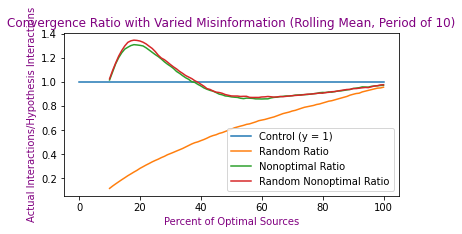

In [286]:
# Same as above plot but now with moving average
# Further comparison of hypothesis games and actual games until convergence (ratio) with visualization.
# Plotting all comparisions now
period = 10

# axis labels and title
plt.xlabel("Percent of Optimal Sources", color='purple')
plt.ylabel("Actual Interactions/Hypothesis Interactions", color='purple')
title = f'Convergence Ratio with Varied Misinformation (Rolling Mean, Period of {period})'
plt.title(title, color='purple')

# ratios
plt.plot(list(range(101)), [1]*101, label="Control (y = 1)")
plt.plot(percent_optimal_agents_random, pd.DataFrame(fraction_actual_games_random).rolling(period).mean(), label="Random Ratio")
plt.plot(percent_optimal_agents_revop, pd.DataFrame(fraction_actual_games_revop).rolling(period).mean(), label="Nonoptimal Ratio")
plt.plot(percent_optimal_agents_ranrevop, pd.DataFrame(fraction_actual_games_ranrevop).rolling(period).mean(), label="Random Nonoptimal Ratio")
plt.legend();
plt.savefig(save_dir + '/' + title + '.png', bbox_inches='tight')

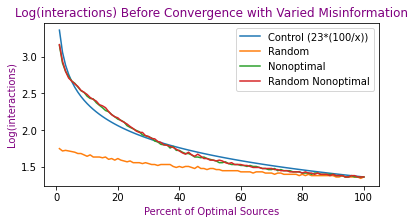

In [287]:
plt.xlabel("Percent of Optimal Sources", color='purple')
plt.ylabel("Log(interactions)", color='purple')
title = 'Log(interactions) Before Convergence with Varied Misinformation'
plt.title(title, color='purple')

def add_agent_to_absolute_plot(percent_op: List[int], games: List[float],
                               agent_name: str) -> None:
    # actual trial data
    plt.plot(percent_op, list(map(log10, games)), label = agent_name)

    # legend
    plt.legend(loc="upper right")

# plot hypothesis
f = lambda x: eval(hypothesis_random)
hypothesis_y = [f(x) for x in percent_optimal_agents_random]
plt.plot(percent_optimal_agents_random, list(map(log10, hypothesis_y)), label = f'Control ({hypothesis_random})')


# agents
add_agent_to_absolute_plot(percent_optimal_agents_random,
                           med_games_until_convergence_random,
                           'Random')
add_agent_to_absolute_plot(percent_optimal_agents_revop,
                           med_games_until_convergence_revop,
                           'Nonoptimal')
add_agent_to_absolute_plot(percent_optimal_agents_ranrevop,
                           med_games_until_convergence_ranrevop,
                           'Random Nonoptimal')

plt.legend();
plt.savefig(save_dir + '/' + title + '.png', bbox_inches='tight')
